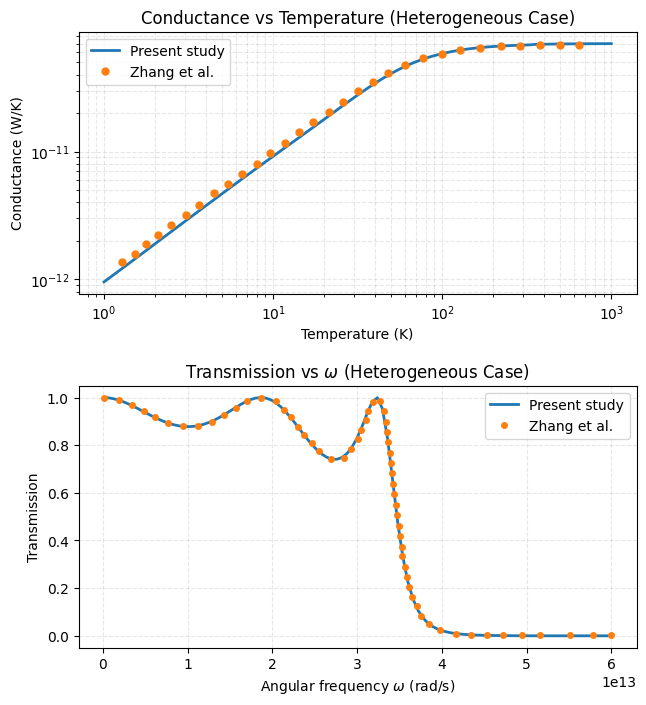

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad


# Constants
H = 6.62607015e-34
HBAR = H / (2 * np.pi)
KB = 1.380649e-23

# Inputs
N = 3
k = 32.0
mc = 4.6e-26
md = 9.2e-26
L = 5.5e-10

OmegaHigh = 6e13
OmegaLow = 0.0
OD = 100
OmegaInterval = (OmegaHigh - OmegaLow) / OD

# Device dynamical matrix H
On_site = (2 * k) / md
Off_site = -(k / md)
Hdev = np.diag(On_site * np.ones(N)) + np.diag(Off_site * np.ones(N - 1), 1) + np.diag(Off_site * np.ones(N - 1), -1)
Hdev = Hdev.astype(complex)

tau_1 = -(k / np.sqrt(mc * md))  # coupling


def delta_broadening(omega):
    return (0.001 * (1 - omega / OmegaHigh)) * omega**2


def surface_g_contact(omega):
    delta = delta_broadening(omega)
    kmc = k / mc

    H_LC = 2 * kmc
    H_LCB_LC = -kmc

    p = (2 * kmc) - (omega**2 + 1j * delta)
    q = -np.sqrt(p**2 - 4 * (kmc**2))
    r = 2 * (kmc**2)
    result = (-p + q) / r

    g = 1.0 / ((omega**2 + 1j * delta) - H_LC - (H_LCB_LC * result * H_LCB_LC))
    return g


def transmission_at_omega_grid():
    omega = np.array([(i + 1) * OmegaInterval + OmegaLow for i in range(OD)], dtype=float)
    T_w = np.zeros_like(omega)

    I = np.eye(N, dtype=complex)

    for i, w in enumerate(omega):
        g_s = surface_g_contact(w)

        SigmaL = np.zeros((N, N), dtype=complex)
        SigmaR = np.zeros((N, N), dtype=complex)
        SigmaL[0, 0] = tau_1 * g_s * tau_1
        SigmaR[N - 1, N - 1] = tau_1 * g_s * tau_1

        G = np.linalg.inv(w**2 * I - Hdev - SigmaL - SigmaR)

        GammaL = 1j * (SigmaL[0, 0] - np.conj(SigmaL[0, 0]))
        GammaR = 1j * (SigmaR[N - 1, N - 1] - np.conj(SigmaR[N - 1, N - 1]))

        T_w[i] = np.real(GammaL * G[0, N - 1] * GammaR * np.conj(G[N - 1, 0]))

    return omega, T_w


def dN_dT(omega, T):
    if T <= 0 or omega <= 0:
        return 0.0

    x = (HBAR * omega) / (KB * T)

    if x > 50:
        y = np.exp(-x)
        fac = y / (1 - y) ** 2
    else:
        exm1 = np.expm1(x)
        ex = exm1 + 1
        fac = ex / (exm1 * exm1)

    return (HBAR * omega) * fac / (KB * T**2)


def transmission_inside_integral(omega):

    delta = delta_broadening(omega)
    kmc = k / mc

    denom = omega**2 - 2 * kmc + 1j * delta
    inside = 1.0 - 4.0 * (kmc**2) / (denom**2)
    A = denom * (1 - np.sqrt(inside)) / (2 * (kmc**2))

    SigmaL = np.zeros((N, N), dtype=complex)
    SigmaR = np.zeros((N, N), dtype=complex)
    SigmaL[0, 0] = tau_1 * A * tau_1
    SigmaR[N - 1, N - 1] = tau_1 * A * tau_1

    I = np.eye(N, dtype=complex)
    G = np.linalg.inv(omega**2 * I - Hdev - SigmaL - SigmaR)

    GammaL = 1j * (SigmaL[0, 0] - np.conj(SigmaL[0, 0]))
    GammaR = 1j * (SigmaR[N - 1, N - 1] - np.conj(SigmaR[N - 1, N - 1]))

    return float(np.real(GammaL * G[0, N - 1] * GammaR * np.conj(G[N - 1, 0])))


def conductance_vs_T():
    Tgrid = np.logspace(0, 3, OD)
    Gth = np.zeros_like(Tgrid)

    for j, T in enumerate(Tgrid):

        def integrand(w):
            phonon_energy = (HBAR * w) / (2 * np.pi)
            return phonon_energy * dN_dT(w, T) * transmission_inside_integral(w)

        val, _ = quad(integrand, OmegaLow, OmegaHigh, limit=200)
        Gth[j] = val

    return Tgrid, Gth


omega, Trans = transmission_at_omega_grid()
Tgrid, Gth = conductance_vs_T()

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(7.2, 8.0), sharex=False
)

# Add space between the two plots
fig.subplots_adjust(hspace=0.35)

# Conductance
ax1.loglog(Tgrid, Gth, linewidth=2, label="Present study")

try:
    ref = np.loadtxt("conductance_heterogeneous.txt", delimiter=",")
    ax1.plot(ref[:, 0], ref[:, 1], "o", markersize=5, label="Zhang et al.")
except OSError:
    pass

ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("Conductance (W/K)")
ax1.set_title("Conductance vs Temperature (Heterogeneous Case)")
ax1.grid(True, which="both", linestyle="--", alpha=0.3)
ax1.legend(loc="upper left")


#  Transmission
ax2.plot(omega, Trans, linewidth=2, label="Present study")

try:
    ref_t = np.loadtxt("transmission_heterogeneous.txt", delimiter=",")
    ax2.plot(ref_t[:, 0], ref_t[:, 1], "o", markersize=4, label="Zhang et al.")
except OSError:
    pass

ax2.set_xlabel(r"Angular frequency $\omega$ (rad/s)")
ax2.set_ylabel("Transmission")
ax2.set_title(r"Transmission vs $\omega$ (Heterogeneous Case)")
ax2.grid(True, linestyle="--", alpha=0.3)
ax2.legend(loc="upper right")

fig.savefig("heterogeneous_conductance_and_transmission.png", dpi=400, bbox_inches="tight")

plt.show()

